## SRJ - Adapt GCIM

In [1]:
#Check the possible excitations
import pennylane as qml
from pennylane import qchem
from pennylane import numpy as np
from itertools import chain
import itertools
import time
import re
import scipy
from scipy.optimize import minimize
import warnings
warnings.filterwarnings("ignore", category=np.ComplexWarning)
ash_excitation = []
energies = []
excitations= []
old_grad = []
excitationlist = []
generatingfns = []
gs_energy = []
grad_GCIM = []  # To store the highest gradient excitation values
operator_check = []  # To store the highest gradient excitation operators
theta = np.pi/4
print('Theta is', theta)

X = qml.PauliX
Y = qml.PauliY
Z = qml.PauliZ
I = qml.Identity



bond_length = 3.0
symbols = ["H","H","H","H"]
electrons = 4
orbitals = 8
r_bohr = bond_length *1.8897259886 
#r_bohr = bond_length * 1.0  # Convert bond length to Bohr radius 
coordinates = np.array([[0.0,0.0, 1*r_bohr], [0.0, 0.0, 2*r_bohr], [0.0,0.0,3*r_bohr],[0.0, 0.0, 4*r_bohr]])
print(coordinates)
H, qubits = qml.qchem.molecular_hamiltonian(symbols, coordinates, basis="sto-6g", method="pyscf")
#hf_state = qchem.hf_state(electrons, qubits)

def adaptvqe(adapt_it = 4, e_th=1e-12):
    ash_excitation = []
    energies = []
    excitations= []
    #Preparation of the Hartree-Fock state in the form of 2^8 states
    dev = qml.device("lightning.qubit", wires=qubits)
    @qml.qnode(dev)
    def hf_stateprep(wires):
        target_state = np.zeros(2**qubits)
        target_state[240] = 1.0 # Every molecule change, you need to change this index
        qml.StatePrep(target_state, wires=range(qubits))
        return qml.state()

    hf_state = hf_stateprep(wires=qubits)
    #print('HF state is', hf_state)

    #Calculation of HF state
    dev = qml.device("lightning.qubit", wires=qubits)
    @qml.qnode(dev)
    def circuit(hf_state, electrons, qubits, H):
        #print('Updated hf_state is', hf_state)  
        qml.StatePrep(hf_state, wires=range(qubits))
        return qml.expval(H)  
    
    @qml.qnode(dev)
    def commutator_0(H,w, k):  #H is the Hamiltonian, w is the operator, k is the basis state - HF state
        qml.StatePrep(k, wires=range(qubits))
        res = qml.commutator(H, w)   #Calculating the commutator
        return qml.expval(res)
    
    # Commutator calculation for other states except HF state
    @qml.qnode(dev)
    def commutator_1(H,w, k): #H is the Hamiltonian, w is the operator, k is the basis state
        qml.StatePrep(k, wires=range(qubits))
        res = qml.commutator(H, w) #Calculating the commutator
        return qml.expval(res)
    #Applyign the givens rotation to the HF state
    @qml.qnode(dev)
    def new_state(hf_state, ash_excitation, qubits):
        qml.StatePrep(hf_state, wires=range(qubits))
        for i in range(len(ash_excitation)):
            if len(ash_excitation[i]) == 4:
                qml.DoubleExcitation(theta, wires=ash_excitation[i])
            elif len(ash_excitation[i]) == 2:
                qml.SingleExcitation(theta, wires=ash_excitation[i])
        return qml.state()
    
    #Measurement of new state
    dev_meas = qml.device("lightning.qubit", wires=qubits, shots=1000)
    @qml.qnode(dev_meas)
    def measure(ostate):
        qml.StatePrep(ostate, wires=range(qubits))
        return qml.counts()
    
    @qml.qnode(dev)
    def ind_state(ash_excitation):
        qml.StatePrep(hf_state, wires=range(qubits))
        print('Individual excitation is', ash_excitation)
        if len(ash_excitation) == 4 :
            qml.DoubleExcitation(theta, wires=ash_excitation)
        elif len(ash_excitation) == 2:
            qml.SingleExcitation(theta, wires=ash_excitation)
        return qml.state()


    print('HF state is', circuit(hf_state, electrons, qubits, H))
    singles, doubles = qml.qchem.excitations(electrons, orbitals)

    
    op1 =  [qml.fermi.FermiWord({(0, x[0]): "+", (1, x[1]): "-"}) for x in singles]
    op2 =  [qml.fermi.FermiWord({(0, x[0]): "+", (1, x[1]): "+", (2, x[2]): "-", (3, x[3]): "-"})for x in doubles]
    operator_pool = (op1) + (op2)  #Operator pool - Singles and Doubles
    print('The operator pool length is', len(operator_pool))
    states = [hf_state]
    max_operator = None

    for j in range(1, adapt_it):
        print('The adapt iteration now is', j)  #Adapt iteration
        max_value = float('-inf')
        #max_operator = None
        k = states[-1] if states else hf_state  # if states is empty, fall back to hf_state
        counts1 = measure(k)  #Measure the current state
        print('The measurement of new state is', counts1)
        print(f'The operator check for this iteration {j} is', operator_check)
        for i in operator_pool:
            if i not in operator_check:  # Check if the operator is already used
                #print('The current excitation operator is', i) #Current excitation operator - fermionic one
                #print('The value of  operator check is', operator_check)  #Max excitation operator
                w = qml.fermi.jordan_wigner(i)  #JW transformation
                if np.array_equal(k, hf_state): # If the current state is the HF state
                    current_value = abs(2*(commutator_0(H, w, k)))      #Commutator calculation is activated  
                else:
                    current_value = abs(2*(commutator_1(H, w, k)))      #For other states, commutator calculation is activated
                #print(f'The expectation value of {i} is', current_value)

                if current_value > max_value:
                    max_value = current_value
                    max_operator = i

        print(f"The highest operator value is {max_value} for operator {max_operator}")  #Highest operator value
        operator_check.append(max_operator)
        grad_GCIM.append(max_value)  # Append the highest operator to the grad_GCIM list
        # Convert operator to excitations and append to ash_excitation
        indices_str = re.findall(r'\d+', str(max_operator))
        excitations1 = [int(index) for index in indices_str]
        print('Highest gradient excitation is', excitations1)
        ash_excitation.append(excitations1)
        print('ash_excitation is', ash_excitation)
        print('The length of ash_excitation before generating matrix is', len(ash_excitation))

        
        #Now apply the givens rotation for it. 
        ostate = new_state(hf_state, ash_excitation, qubits)
        print(qml.draw(new_state, max_length=100)(hf_state,ash_excitation, qubits))
        #Measuring the state
        counts = measure(ostate)
        print('State count after Generating function is', counts)
        if j >= 2:
            states.append(ind_state(ash_excitation[-1]))  # Append the individual excitation state
        else:
            print('Skipping individual excitation state for j < 2')
        states.append(ostate)
        print(f'After adding the states the adapt iteration is {j} and no of states',len(states))
        M = np.zeros((len(states), len(states)), dtype=complex)  # Initialize H with zeros
        S = np.zeros((len(states), len(states)), dtype=complex)  # Initialize S matrix with zeros
        Ham_matrix = qml.matrix(H, wire_order=range(qubits))  # Get the Hamiltonian matrix
        print('Shape of Hamiltonian matrix is', Ham_matrix.shape)
        # Now we need to fill the H and S matrices
        for i in range(len(states)):
            for j in range(len(states)):
                print('The value of i and j is', i, j)
                left_op = states[i].T.conj()
                right_op = states[j]
                M[i,j] = left_op.dot(Ham_matrix.dot(right_op)).real
                S[i,j] = left_op.dot(right_op).real
     
                
                if i != j:
                    M[j,i] = M[i,j].conj()
                    S[j,i] = S[i,j].conj()
        n = S.shape[0]
        epsilon = 1e-10
        S_reg = S + epsilon * np.eye(n)
        #print(f'S matrix with {i} and {j} is', S)
        #print('Hamiltonian Matrix with', i, j, 'is', M)
        print('The shape of S matrix is', S.shape)  
        eig,evec=scipy.linalg.eigh(M,S_reg)
        print('Eigenvalues are', eig)
        gs_energy.append(eig[0])
        print('Ground state energy is', gs_energy) 
          
    return ash_excitation, states,eig,gs_energy, Ham_matrix,hf_state, grad_GCIM


Theta is 0.7853981633974483
[[ 0.          0.          5.66917797]
 [ 0.          0.         11.33835593]
 [ 0.          0.         17.0075339 ]
 [ 0.          0.         22.67671186]]


In [2]:
ash_excitation, states,eig,gs_energy,Ham_matrix, hf_state, grad_GCIM = adaptvqe(adapt_it=16, e_th=1e-12)

HF state is -1.3325688880668918
The operator pool length is 26
The adapt iteration now is 1
The measurement of new state is {'11110000': 1000}
The operator check for this iteration 1 is []
The highest operator value is 0.31004515885821066 for operator a⁺(2) a⁺(3) a(6) a(7)
Highest gradient excitation is [2, 3, 6, 7]
ash_excitation is [[2, 3, 6, 7]]
The length of ash_excitation before generating matrix is 1
0: ─╭|Ψ⟩───────────┤  State
1: ─├|Ψ⟩───────────┤  State
2: ─├|Ψ⟩─╭G²(0.79)─┤  State
3: ─├|Ψ⟩─├G²(0.79)─┤  State
4: ─├|Ψ⟩─│─────────┤  State
5: ─├|Ψ⟩─│─────────┤  State
6: ─├|Ψ⟩─├G²(0.79)─┤  State
7: ─╰|Ψ⟩─╰G²(0.79)─┤  State
State count after Generating function is {'11000011': 149, '11110000': 851}
Skipping individual excitation state for j < 2
After adding the states the adapt iteration is 1 and no of states 2
Shape of Hamiltonian matrix is (256, 256)
The value of i and j is 0 0
The value of i and j is 0 1
The value of i and j is 1 0
The value of i and j is 1 1
The shape of S matrix

In [4]:
print(grad_GCIM)
print(gs_energy)

[0.31004515885821066, 0.3658436432870543, 0.415301903154508, 0.43551984378007924, 0.10116790265495315, 0.19291610775387852, 0.1551048081119453, 0.0777894284035248, 0.053823303629584825, 0.13446580865057253, 0.05543592677909406, 0.07891914355251453, 0.03527710880924973, 0.03925426307787975, 1.802756174038156e-49]
[-1.430083670535935, -1.5694603832062615, -1.7440626565880086, -1.8660667753404518, -1.8688240410155197, -1.8757124515908579, -1.8784192149543435, -1.881322338900651, -1.8813235735667297, -1.8813235737748255, -1.8843440687031336, -1.885124900072603, -1.8851249009961162, -1.8851249035113442, -1.8851249035113442]


15
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14]


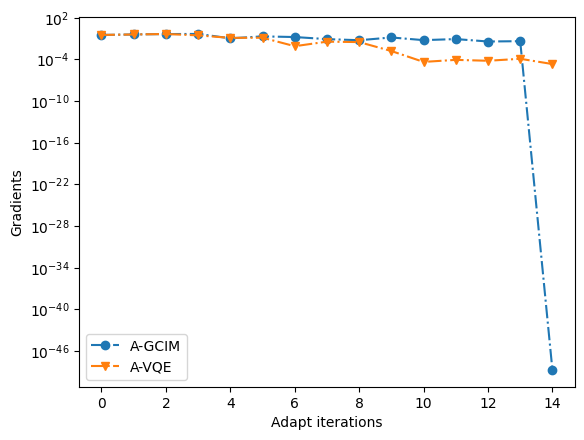

In [3]:
#Adapt GCIM ones
import numpy as np
grad_GCIM = [0.31004515885821066, 0.3658436432870543, 0.415301903154508, 0.43551984378007924, 0.10116790265495315, 0.19291610775387852, 0.1551048081119453, 0.0777894284035248, 0.053823303629584825, 0.13446580865057253, 0.05543592677909406, 0.07891914355251453, 0.03527710880924973, 0.03925426307787975, 1.802756174038156e-49]
print(len(grad_GCIM))
gs_energy = [-1.430083670535935, -1.5694603832062615, -1.7440626565880086, -1.8660667753404518, -1.8688240410155197, -1.8757124515908579, -1.8784192149543435, -1.881322338900651, -1.8813235735667297, -1.8813235737748255, -1.8843440687031336, -1.885124900072603, -1.8851249009961162, -1.8851249035113442, -1.8851249035113442]

old_grad = [0.3100451588582031, 0.36333417053141476, 0.4247574391897041, 0.26894207751270327, 0.11800197737818896, 0.12345362107538944, 0.007420243183015195, 0.03354582808357999, 0.02906182006714331, 0.001491669217834793, 4.058152607581663e-05, 7.98763663883411e-05, 5.916664708532221e-05, 0.00011468136338948359, 1.9917904284355234e-05]


it = np.arange(15)
print(it)
import matplotlib.pyplot as plt
plt.plot(it, grad_GCIM, '-.o', label = 'A-GCIM')
plt.plot(it, old_grad , '-.v', label ='A-VQE')
plt.legend()
plt.yscale('log')
plt.xlabel('Adapt iterations')
plt.ylabel('Gradients')
plt.show()

14
14
14
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13]


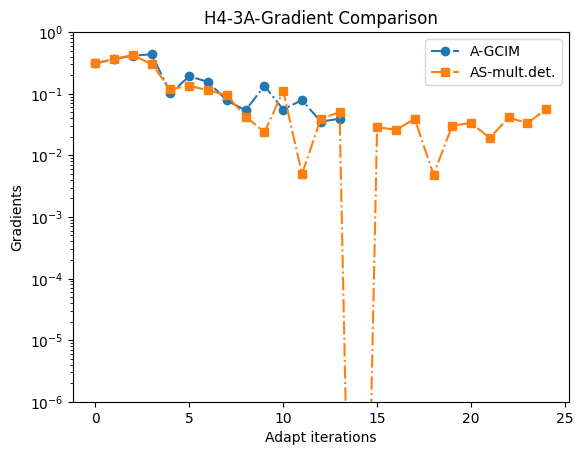

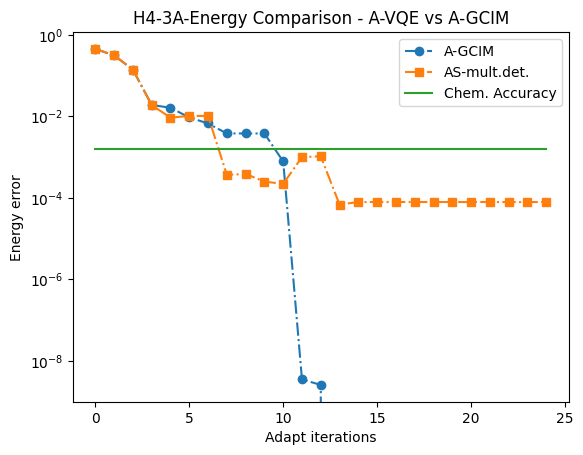

In [22]:
import numpy as np
grad_GCIM = [0.31004515885821066, 0.3658436432870543, 0.415301903154508, 0.43551984378007924, 0.10116790265495315, 0.19291610775387852, 0.1551048081119453, 0.0777894284035248, 0.053823303629584825, 0.13446580865057253, 0.05543592677909406, 0.07891914355251453, 0.03527710880924973, 0.03925426307787975]
print(len(grad_GCIM))
gs_energy = [-1.430083670535935, -1.5694603832062615, -1.7440626565880086, -1.8660667753404518, -1.8688240410155197, -1.8757124515908579, -1.8784192149543435, -1.881322338900651, -1.8813235735667297, -1.8813235737748255, -1.8843440687031336, -1.885124900072603, -1.8851249009961162, -1.8851249035113442]
print(len(gs_energy))


FCI = -1.8851249035113442
E_FCI = np.full((len(gs_energy)), FCI)

chem_accuracy = 1.59e-3
E_chem = np.full((len(gs_energy)), chem_accuracy)

gs_error = gs_energy - E_FCI
old_grad = [0.3100451588582031, 0.36333417053141476, 0.4247574391897041, 0.26894207751270327, 0.11800197737818896, 0.12345362107538944, 0.007420243183015195, 0.03354582808357999, 0.02906182006714331, 0.001491669217834793, 4.058152607581663e-05, 7.98763663883411e-05, 5.916664708532221e-05, 0.00011468136338948359]
old_energy =  [-1.4300836708403635, -1.5694603835521455, -1.743633442615136, -1.8421101514364009, -1.8504359363287832, -1.8594600250247437, -1.8656767410818602, -1.8663879748308778, -1.8843560330008289, -1.8844361654205786, -1.8844361671811045, -1.884436452216252, -1.8844364556732816, -1.8844365760084552]
print(len(old_energy))
oenergy_error = old_energy - E_FCI




# ARS energy - Used full state for gradient calculations. - ARS full state.ipynb file name - 26 iterations
arsenergy = [-1.430083670662174, -1.56946038355194, -1.7440626583933085, -1.8660667755314557, -1.8758503116037928, -1.8748039179430127, -1.8749029903786418, -1.8847595703351097, -1.8847397747260157, -1.8848753355482748, -1.8849052007883016, -1.8841258211020733, -1.8840790587008942, -1.885056904271258, -1.8850462888550639, -1.8850463152526293, -1.885046076981161, -1.8850460692429851, -1.8850463162647817, -1.8850462201734701, -1.8850464440909052, -1.8850460145998182, -1.885046541346139, -1.8850464625218146, -1.8850462950867615]
FCI_full = -1.8851249035113442
E_FCI_full = np.full((len(arsenergy)), FCI_full)
E_chem_full = np.full((len(arsenergy)), chem_accuracy)

arserror = arsenergy - E_FCI_full
ars_grad = [0.3100451588582031, 0.36625718143639074, 0.4230543672527128, 0.3002278044154616, 0.11844160289748043, 0.13421648942894546, 0.11419411542737172, 0.09404847127599394, 0.04261504907320243, 0.023742937361961192, 0.10976606381706597, 0.004974043635226709, 0.03908227037095724, 0.050211039588864394, 1.2204208395367173e-16, 0.028723263875166327, 0.025929181504883478, 0.03891926505473271, 0.004862268731390583, 0.030437966512643515, 0.03348780917636539, 0.019123528886453998, 0.04130402192278884, 0.03315530486686505, 0.0567742206253946]

# Case 2: Usage of single determinant for gradient calculations |s1>
arsenergy_sdet =  [-1.430083670662174, -1.56946038355194, -1.7440626583933085, -1.8660667755314557, -1.8758503116042369, -1.8835192725160552, -1.8832018741837144, -1.8830798945612264, -1.883488000610656, -1.8848742852942832, -1.8849779254284131, -1.8849115567829753, -1.8849892293543276, -1.8850812589466992, -1.8850807692378262, -1.8850807692369618, -1.885080769131067, -1.8850807692425464, -1.8850807692706966, -1.8850791322301688, -1.8850807673647374, -1.8850784049976537, -1.8850807691220675, -1.885079327266876, -1.885078327884024]

ars_error_sdet = arsenergy_sdet - E_FCI_full

ars_grad_sdet = [0.3100451588582031, 0.34678322371546566, 0.38589301231067186, 0.1810372345005346, 0.11394892475060205, 0.11979485988740776, 0.044175187120723804, 0.034612142891874524, 0.041368871148446736, 0.019715325428236515, 0.04260329824431383, 0.10382203151933021, 0.01005024199340257, 0.0006764585287712772, 2.710502764656108e-16, 6.187791355064812e-07, 1.5140447842136072e-06, 1.816279910176091e-06, 2.843093662486155e-07, 1.0285746008151453e-05, 0.0025328875123424577, 1.7079954995990637e-05, 0.00266637440341904, 7.308897263512076e-06, 0.002577408560250764]


it = np.arange(14)
it_full = np.arange(25)
print(it)
import matplotlib.pyplot as plt
plt.plot(it, grad_GCIM, '-.o', label = 'A-GCIM')
#plt.plot(it, old_grad , '-.v', label ='A-VQE')
plt.plot(it_full, ars_grad, '-.s', label = 'AS-mult.det.')
#plt.plot(it_full, ars_grad_sdet, '-.d', label = 'AS-Single det.')
plt.legend()
plt.yscale('log')
plt.ylim(1e-6, 1e0)
#plt.xlim(0, 14)
plt.xlabel('Adapt iterations')
plt.ylabel('Gradients')
plt.title('H4-3A-Gradient Comparison')
plt.show()

plt.plot(it, gs_error, '-.o', label = 'A-GCIM')
#plt.plot(it, oenergy_error , '-.v', label ='A-VQE')
plt.plot(it_full, arserror, '-.s', label = 'AS-mult.det.')
#plt.plot(it_full, ars_error_sdet, '-.d', label = 'AS-Single det.')
plt.plot(it_full, E_chem_full, '-', label = 'Chem. Accuracy')
plt.legend()
plt.yscale('log')
plt.xlabel('Adapt iterations')
plt.ylabel('Energy error')
plt.title('H4-3A-Energy Comparison - A-VQE vs A-GCIM')
plt.show()

In [14]:
arsenergy[-1] - FCI

7.860842458273787e-05

In [2]:
aserror

array([4.55041234e-01, 3.15664520e-01, 1.41062245e-01, 1.90581280e-02,
       9.27459191e-03, 1.60563100e-03, 1.67999641e-03, 1.41306614e-03,
       7.83273411e-04, 7.82368778e-04, 7.81619964e-04, 7.81111417e-04,
       2.29572484e-05, 3.82671824e-05])